# Modeling California Housing Prices
Now that exploration and preliminary work has been done in *Housing_Expl.ipynb*, setup the feature work and modeling pipelines.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Set Up Functions for the Pipelines

In [2]:
# custom "transformer" to select types of columns & return the data as np array
class DFSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attNames):
        self.attributeNames = attNames
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.attributeNames].values

In [3]:
# custom "transformer" to do some numeric feature engineering
class FeatEngineer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # compute some new features
        roomsHouse = X[:,3]/X[:,6]
        bedroomsHouse = X[:,4]/X[:,6]
        populationHouse = X[:,5]/X[:,6]  
        return np.c_[X,roomsHouse,bedroomsHouse,populationHouse]

In [4]:
# create a function to perform stratified sampling
def StratPartition(training_perc,split_seed,data,categories):
    sss = StratifiedShuffleSplit(n_splits=1, random_state = split_seed, train_size = training_perc)
    trn,tst = next(sss.split(data,categories))
    return data.loc[trn],data.loc[tst]

## Do the work

In [5]:
# get the data
HOUSING_PATH = './datasets/housing'
HOUSING_FILE = 'housing.csv'
housingData = pd.read_csv(os.path.join(HOUSING_PATH,'housing.csv'))
# get numeric and categorical columns separately
featuresCat = []
featuresNum = []
for col,typ in zip(housingData.columns,housingData.dtypes):
    if col=='median_house_value':
        # note that we exclude the target variable, as we don't want to do anything to it
        pass
    elif (typ=='float64') or (typ=='int64'):
        featuresNum.append(col)
    else:
        featuresCat.append(col)

In [6]:
# handles nulls in the target by dropping the rows
housingData = housingData[pd.notnull(housingData.median_house_value)]

# create the categorical income variable, and partition into training & testing sets
housingData['median_income_cat'] = np.ceil(housingData.median_income/1.5)
housingData.median_income_cat.where(housingData.median_income_cat<5,5,inplace=True)
housingData.median_income_cat = pd.Categorical(housingData.median_income_cat)

# partition, using stratifications of the median income
splitSeed = 19062018
trainingPerc = 0.75
housingTrn,housingTst = StratPartition(trainingPerc,splitSeed,housingData,housingData.median_income_cat)
# talk a little
print('Training Set:')
print(housingTrn.median_income_cat.value_counts().sort_values()/housingTrn.median_income_cat.count())
print('Testing Set:')
print(housingTst.median_income_cat.value_counts().sort_values()/housingTst.median_income_cat.count())

# now save this feature separately & drop it
medIncomeCatTrn = housingTrn.median_income_cat; housingTrn.drop('median_income_cat',axis=1,inplace=True)
medIncomeCatTst = housingTst.median_income_cat; housingTst.drop('median_income_cat',axis=1,inplace=True)

# extract and set aside the target        
housingTargTrn = housingTrn.median_house_value; housingTrn.drop('median_house_value',axis=1,inplace=True)
housingTargTst = housingTst.median_house_value; housingTst.drop('median_house_value',axis=1,inplace=True)

Training Set:
1.0    0.039793
5.0    0.114470
4.0    0.176292
2.0    0.318863
3.0    0.350581
Name: median_income_cat, dtype: float64
Testing Set:
1.0    0.039729
5.0    0.114341
4.0    0.176357
2.0    0.318798
3.0    0.350775
Name: median_income_cat, dtype: float64


/home/ahowe42/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1639: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Note: what about the ridiculously high numbers of rooms?; what about the apparent cutoffs in home values?

In [7]:
# set up some scikit-learn objects
selNum = DFSelector(featuresNum)
selCat = DFSelector(featuresCat)
enc = LabelBinarizer()           # create OHE cat labels for the categorical variable(s)
imp = Imputer(strategy='median') # impute missing numeric values using the median
von = MinMaxScaler()             # scale numeric values to the [0,1] von Neuman range
eng = FeatEngineer()             # engineer some numeric features

# create the transformation pipelines
pipeNum = Pipeline([('selector',selNum),('imputer',imp),('engineer',eng),('normalizer',von)])
pipeCat = Pipeline([('selector',selCat),('binner',enc)])
pipeFull = FeatureUnion(transformer_list=[('numeric',pipeNum),('categoric',pipeCat)])

Note: there is an issue with Pipeline, it seems, that prevents it working with the *LabelBinarizer()*, so I've set it up, but not using it...

In [8]:
# run the full pipelines
#housingTrn = pipeFull.fit_transform(housingTrn)
#housingTst = pipeFull.transform(housingTst)

# run the numeric pipline
numTrn = pipeNum.fit_transform(housingTrn)
numTst = pipeNum.transform(housingTst)
print('Numeric shapes = %r, %r'%(numTrn.shape,numTst.shape))

# pretend we are running the categorical pipeline
catTrn = selCat.fit_transform(housingTrn)
catTrn = enc.fit_transform(catTrn)
catTst = selCat.transform(housingTst)
catTst = enc.transform(catTst)
print('Categoric shapes = %r, %r'%(catTrn.shape,catTst.shape))

Numeric shapes = (15480, 11), (2064, 11)
Categoric shapes = (15480, 5), (2064, 5)


In [9]:
# put the data all back together
cols = featuresNum+['rooms_per_house','bedrooms_per_house','population_per_house']+\
['ocean_proximity_%d'%i for i in range(len(housingData.ocean_proximity.value_counts()))]+['median_income_cat']
housingTrn = pd.DataFrame(np.c_[numTrn,catTrn,medIncomeCatTrn],columns=cols)
housingTst = pd.DataFrame(np.c_[numTst,catTst,medIncomeCatTst],columns=cols)
# talk
print('---------- Training')
print(housingTrn.describe())
print(housingTrn.head())
print('---------- Testing')
print(housingTst.describe())
print(housingTst.head())

---------- Training
          longitude      latitude  housing_median_age   total_rooms  \
count  15480.000000  15480.000000        15480.000000  15480.000000   
mean       0.475349      0.329878            0.543489      0.066614   
std        0.199923      0.227774            0.246639      0.055491   
min        0.000000      0.000000            0.000000      0.000000   
25%        0.253984      0.148346            0.333333      0.036679   
50%        0.581673      0.183565            0.549020      0.053759   
75%        0.631474      0.550694            0.705882      0.079285   
max        1.000000      1.000000            1.000000      1.000000   

       total_bedrooms    population    households  median_income  \
count    15480.000000  15480.000000  15480.000000   15480.000000   
mean         0.082724      0.049453      0.081451       0.232501   
std          0.064436      0.038648      0.061934       0.131076   
min          0.000000      0.000000      0.000000       0.000000   


# Time to try some modeling

In [10]:
# try multiple least squares linear regression
linReg = LinearRegression(n_jobs=-1)
linReg.fit(X = housingTrn,y=housingTargTrn)
trnLinPred = linReg.predict(X = housingTrn)
tstLinPred = linReg.predict(X = housingTst)
# evaluate MSE
trnLinMSE = mean_squared_error(housingTargTrn,trnLinPred)
tstLinMSE = mean_squared_error(housingTargTst,tstLinPred)
print('Linear Regression\nTraining RMSE = %0.2f\nTesting RMSE = %0.2f'%(math.sqrt(trnLinMSE),math.sqrt(tstLinMSE)))

Linear Regression
Training RMSE = 68532.11
Testing RMSE = 67842.93


In [11]:
# try a decision tree regressor
treReg = DecisionTreeRegressor()
treReg.fit(X = housingTrn,y=housingTargTrn)
trnTrePred = treReg.predict(X = housingTrn)
tstTrePred = treReg.predict(X = housingTst)
# evaluate MSE
trnTreMSE = mean_squared_error(housingTargTrn,trnTrePred)
tstTreMSE = mean_squared_error(housingTargTst,tstTrePred)
print('Decision Tree Regression\nTraining RMSE = %0.2f\nTesting RMSE = %0.2f'%(math.sqrt(trnTreMSE),math.sqrt(tstTreMSE)))

Decision Tree Regression
Training RMSE = 0.00
Testing RMSE = 70706.69


Now instead of doing our own random shuffle split, let's use the cv scoring capability of *scikit-learn*.

In [12]:
# first put the data back together
housing_X = pd.concat([housingTrn,housingTst])
housing_y = pd.concat([housingTargTrn,housingTargTst])
# run 100 cv splits
linRegScores = np.sqrt(-cross_val_score(linReg,X=housing_X,y=housing_y,scoring='neg_mean_squared_error',
                                        cv=100,n_jobs=-1))
treRegScores = np.sqrt(-cross_val_score(treReg,X=housing_X,y=housing_y,scoring='neg_mean_squared_error',
                                        cv=100,n_jobs=-1))
# compute stats
lrMn = np.mean(linRegScores)
lrSd = np.std(linRegScores)
lrCI = [lrMn-2*lrSd,lrMn +2*lrSd]
dtMn = np.mean(treRegScores)
dtSd = np.std(treRegScores)
dtCI = [dtMn-2*dtSd,dtMn +2*dtSd]

((array([ 5., 14., 18., 21., 18., 12.,  5.,  3.,  3.,  1.]),
  array([56072.73819939, 59709.93351219, 63347.12882499, 66984.32413778,
         70621.51945058, 74258.71476338, 77895.91007618, 81533.10538898,
         85170.30070178, 88807.49601458, 92444.69132737]),
  <a list of 10 Patch objects>),
 Text(0.5,1,'Decision Tree Regression (69931)\n95% CI: [55683,84178]'))

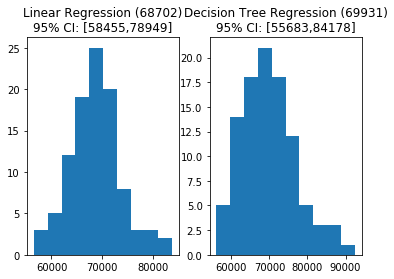

In [13]:
# display results
fh = plt.figure()
plt.subplot(1,2,1)
plt.hist(linRegScores),plt.title('Linear Regression (%d)\n95%% CI: [%d,%d]'%(lrMn,lrCI[0],lrCI[1]))
plt.subplot(1,2,2)
plt.hist(treRegScores),plt.title('Decision Tree Regression (%d)\n95%% CI: [%d,%d]'%(dtMn,dtCI[0],dtCI[1]))

((array([ 8., 15., 15., 21., 11., 21.,  4.,  3.,  1.,  1.]),
  array([40154.73770365, 42750.43608377, 45346.1344639 , 47941.83284402,
         50537.53122415, 53133.22960427, 55728.92798439, 58324.62636452,
         60920.32474464, 63516.02312476, 66111.72150489]),
  <a list of 10 Patch objects>),
 Text(0.5,1,'Random Forest Regression (49830)\n95% CI: [39716,59944]'))

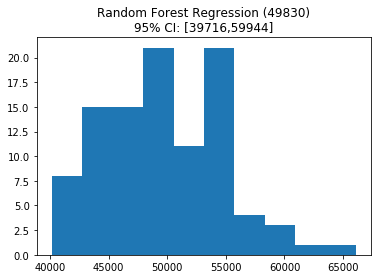

In [14]:
# finally, let's see if we can do best with a random forest
ranFor = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state = splitSeed)
# run 100 CVs
ranForScores = np.sqrt(-cross_val_score(ranFor,X=housing_X,y=housing_y,scoring='neg_mean_squared_error',
                                        cv=100,n_jobs=-1))
# compute stats
rfMn = np.mean(ranForScores)
rfSd = np.std(ranForScores)
rfCI = [rfMn-2*rfSd,rfMn +2*rfSd]
# show performance
plt.hist(ranForScores),plt.title('Random Forest Regression (%d)\n95%% CI: [%d,%d]'%(rfMn,rfCI[0],rfCI[1]))